# Predict customer churn

In this notebook we will build a model to predict, based on the available data, if a customer of a telecom company will churn. The model will use a well-known classification algorithm, the [k-nearest neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm), which simply look at the k closest labeled data point and takes a majority vote.

The notebook is organized as follows:
1. Exploratory analysis to clean and visualize the data
2. Data preprocessing
3. Building the model, test it and evaluate its performance.
4. Implement a pipeline that [explore different classifier](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py) and their performances.

As a final note, the data has been collected from an Iranian Telecom company. The original dataset, alongside references for the published analysis can be found [here](https://www.kaggle.com/datasets/royjafari/customer-churn). 


### 1. Exploratory analysis & cleaning

Let's start to explore the dataset. All the feature are quite self-explanatory for what they represent. The only exceptions are `Customer Value`, `FN` and `FP`. Following the [dataset description](https://www.kaggle.com/datasets/royjafari/customer-churn) they are the result of the analysis performed by the researchers when trying to infer the value of a customer from the company's point of view. We are not interested for now in their analysis so we can drop these features.
Notice that we can also drop the `Age group` feature since it is redundant with the `Age` one.

In [75]:
import pandas as pd

#import the database
df = pd.read_csv("./Customer Churn.csv")

#drop irrelevant features
df=df.drop(columns=['Age Group','Customer Value','FN','FP'])

#rename columns for more compact labels
df=df.rename(columns={"Call  Failure": "call_fail",
                "Complains": "complains",
                "Subscription  Length":"sub_length",
                "Charge  Amount":"charge_amount",
                "Seconds of Use":"sec_of_use",
                "Frequency of use":"freq_of_use",
                "Frequency of SMS":"freq_of_sms",
                "Distinct Called Numbers":"dist_call_num",
                "Tariff Plan":"tariff_plan",
                "Status":"status",
                "Age":"age",
                "Churn":"churn"})

#display the first few rows
display(df.head())

#display the info about the type and null values
df.info()

#display the basic statistics of the dataset
display(df.describe())

,call_fail,complains,sub_length,charge_amount,sec_of_use,freq_of_use,freq_of_sms,dist_call_num,tariff_plan,status,age,churn
0,8,0,38,0,4370,71,5,17,1,1,30,0
1,0,0,39,0,318,5,7,4,1,2,25,0
2,10,0,37,0,2453,60,359,24,1,1,30,0
3,10,0,38,0,4198,66,1,35,1,1,15,0
4,3,0,38,0,2393,58,2,33,1,1,15,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   call_fail      3150 non-null   int64
 1   complains      3150 non-null   int64
 2   sub_length     3150 non-null   int64
 3   charge_amount  3150 non-null   int64
 4   sec_of_use     3150 non-null   int64
 5   freq_of_use    3150 non-null   int64
 6   freq_of_sms    3150 non-null   int64
 7   dist_call_num  3150 non-null   int64
 8   tariff_plan    3150 non-null   int64
 9   status         3150 non-null   int64
 10  age            3150 non-null   int64
 11  churn          3150 non-null   int64
dtypes: int64(12)
memory usage: 295.4 KB


,call_fail,complains,sub_length,charge_amount,sec_of_use,freq_of_use,freq_of_sms,dist_call_num,tariff_plan,status,age,churn
count,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000
mean,7.627937,0.076508,32.541905,0.942857,4472.459683,69.460635,73.174921,23.509841,1.077778,1.248254,30.998413,0.157143
std,7.263886,0.265851,8.573482,1.521072,4197.908687,57.413308,112.237560,17.217337,0.267864,0.432069,8.831095,0.363993
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,15.000000,0.000000
25%,1.000000,0.000000,30.000000,0.000000,1391.250000,27.000000,6.000000,10.000000,1.000000,1.000000,25.000000,0.000000
50%,6.000000,0.000000,35.000000,0.000000,2990.000000,54.000000,21.000000,21.000000,1.000000,1.000000,30.000000,0.000000
75%,12.000000,0.000000,38.000000,1.000000,6478.250000,95.000000,87.000000,34.000000,1.000000,1.000000,30.000000,0.000000
max,36.000000,1.000000,47.000000,10.000000,17090.000000,255.000000,522.000000,97.000000,2.000000,2.000000,55.000000,1.000000


Luckily, the database has already been cleaned for us. No value is missing and categorical features are already in a numeric form.

One important feature is for example that the churn rate in the dataset is close to 16%, which makes the two classes unbalanced. Of course a company would like the churn rate to be as low as possible.

### 2. Feature selection

One important thing to understand is if there are some evident pattern/correlations in our data. We thus chose two simple visualizations

- **Correlation Matrix:** check for any evident linear relation between the features and the target variable.
- **Pair Plots:** check for any evident cluster in churn for pairs of features

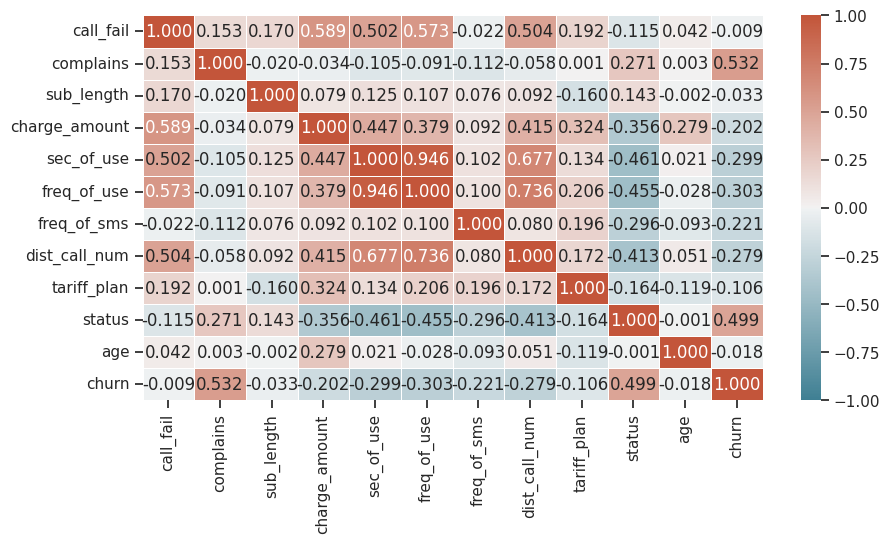

In [76]:
# calculate correlation
df_corr = df.corr()

#import matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

#plot heatmap correlation matrix
plt.figure(figsize=(10,5))
sns.heatmap(df_corr,
            annot=True,
            fmt=".3f",
            vmin=-1,
            vmax=1, 
            linewidths=.5, 
            #cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)
            cmap = sns.diverging_palette(220, 20, as_cmap=True)
            )
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

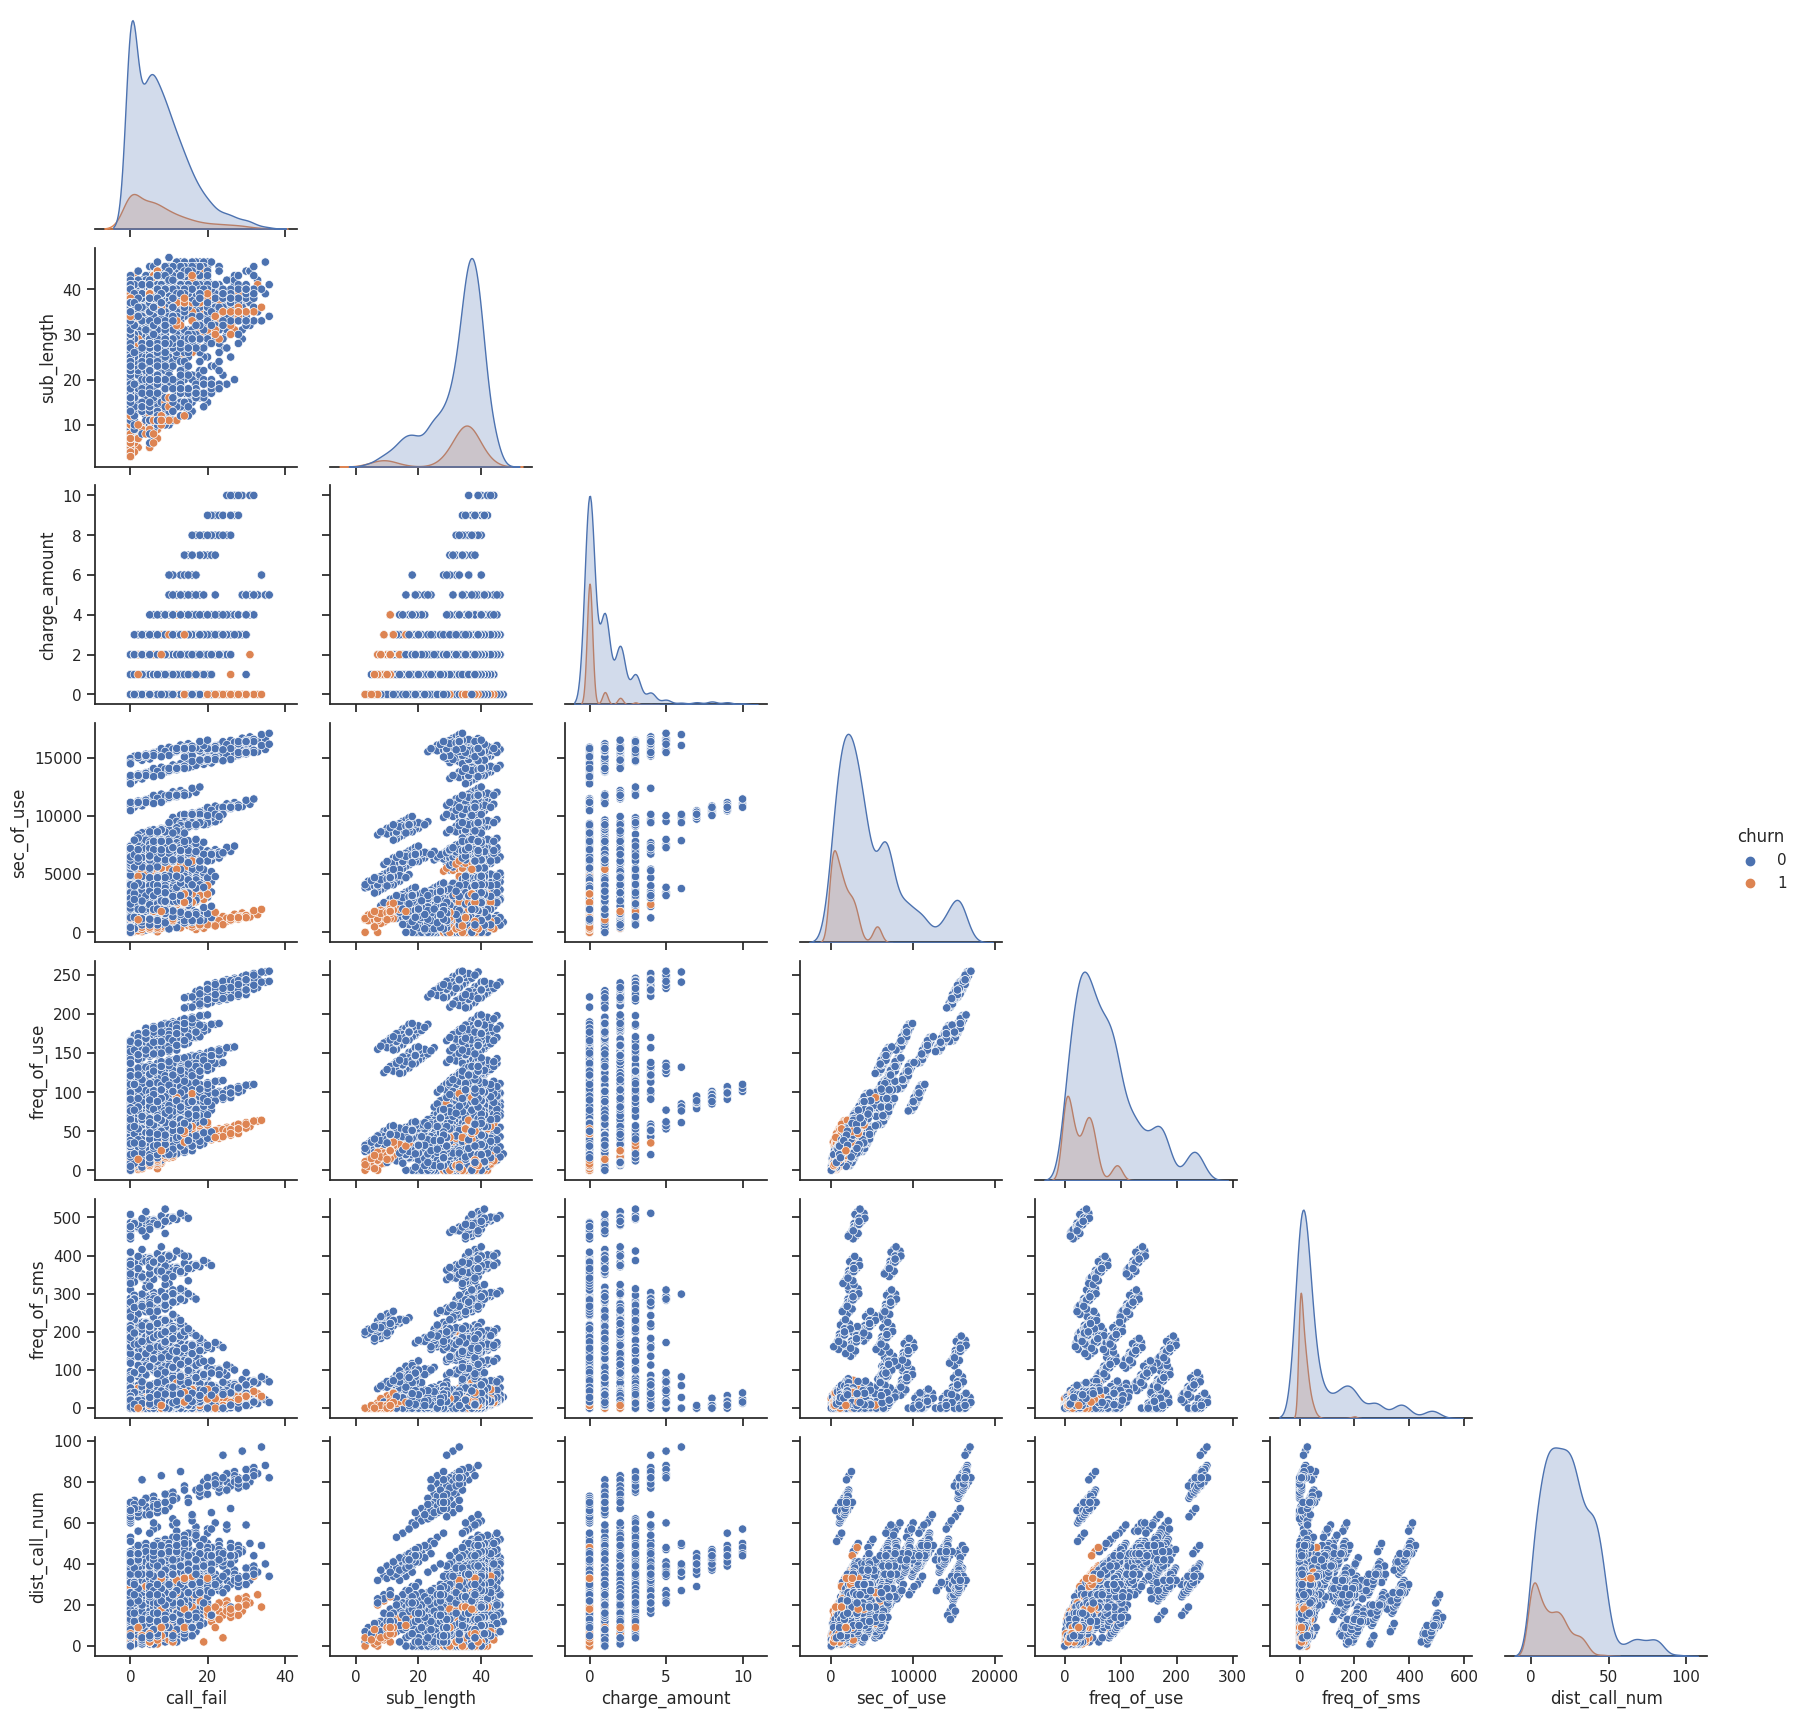

In [77]:
#select relevant columns for pairplot
cont_feature_col=['call_fail','sub_length','charge_amount','sec_of_use','freq_of_use','freq_of_sms','dist_call_num']

#pairplot
sns.pairplot(df[ cont_feature_col+['churn'] ], hue='churn', corner=True)
#sns.set(style="ticks")

### 3. Preprocessing the data

While the plots above are beautiful it seems difficult to identify any clustering or patterns in the data. This is typical in a multi-dimensional feature space and is the main reason to develop Machine Learning (ML) models. Before jumping into that we need first to 

1. Split the data into a train and a test set for performance evaluation later
2. Preprocess the data to make it more digestible by ML models.

In [78]:
#Arrays of the features and the target variable
X = df.drop('churn', axis=1).values
y = df['churn'].values

#Import tools to split data into train/test
from sklearn.model_selection import train_test_split

#Split data for train and test 
#   -stratify to capture the unbalance
#   -set a seed for reproducibility
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.2, stratify=y,random_state=2023)

#scale the data
from sklearn.preprocessing import StandardScaler
X_train_scaled=StandardScaler().fit_transform(X_train)
X_test_scaled=StandardScaler().fit_transform(X_test)

To start, we will use one of the simplest supervised classifier, the k-nearest neighbor.  

In [79]:
#import the classifier
from sklearn.neighbors import KNeighborsClassifier

#initialize the model
knn= KNeighborsClassifier(n_neighbors=5)

#fit the model
knn.fit(X_train_scaled,y_train)

#score
knn.score(X_test_scaled,y_test)

0.9444444444444444